In [ ]:
import numpy as np
import scipy
import pandas
import matplotlib.pyplot as plt
import subprocess
import time


# Bajamos los datos

In [ ]:
# !wget -O datos.zip https://www.dropbox.com/scl/fi/v6qfj1ktarocr8sl02r8k/datos.zip?rlkey=2u060s5619gvcvnnnhq93rn4e&st=jy3dah88&dl=1
# !unzip datos.zip

In [ ]:
class_names = ["T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# Cargamos los archivos

In [ ]:
X_train = np.loadtxt("datos/X_train.csv", delimiter=",") #Funcón de numpy que carga texto (En nuestro caso las imagenes)
y_train = np.loadtxt("datos/y_train.csv", delimiter=",").astype(int) # Indice entero de que clase es cada imagen, hay 5000
X_test = np.loadtxt("datos/X_test.csv", delimiter=",") # Variables test son las de prueba, NO USAR
y_test = np.loadtxt("datos/y_test.csv", delimiter=",").astype(int) # Indice de las imagenes de PRUEBA

X_train.shape, y_train.shape, X_test.shape, y_test.shape


# Revisamos la cantida de muestras por cada clase

In [ ]:
np.bincount(y_train), np.bincount(y_test) # Cuenta cuántos ceros hay, cuántos unos hay, etc.. Hay 500 de cada uno en los datos de entrenamiento y 50 de cada uno en los datos de prueba

# Visualizamos

In [ ]:
ix = 7 #Agarro el elemento numero 7
plt.imshow(X_test[ix].reshape(28,28), cmap="gray") #Reshape para acomodarlo en 28 * 28 (cuadrado)
plt.title(class_names[y_test[ix]]); #Le pone el nombre ... chequea que está bien (coincide el titulo con la imagen)

# Separamos en datos de desarrollo

Garantizamos que las clases siguen igualmente balanceadas (estratificación)

In [ ]:
from sklearn.model_selection import train_test_split
X_newtrain, X_dev, y_newtrain, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train) # Test size = 20%, divide un quinto para reservar como desarrollo.
#Stratify garantiza que todo lo que metió en ese 20% tiene la misma cantidad de prendas de ropa que en el resto

np.bincount(y_newtrain), np.bincount(y_dev) #New Train = E , y_dev = Desarrollo

# 1.KNN

### Implementación en Python

In [ ]:
# Calcula la distancia coseno entre dos vectores A y B
def distance(A, B):
    dot_product = A.dot(B)  # producto interno entre A y B
    norm_product = np.linalg.norm(A) * np.linalg.norm(B)  # producto de las normas de A y B
    return 1 - (dot_product / norm_product) 



#image set = lista de tuplas, con cada tupla = (imagen(vector), typo de imagen)
# Calcula las distancias entre una imagen y un conjunto de imágenes etiquetadas
def image_distances(image_set, image):
    distances = []
    for pic, label in image_set:  # Itera sobre cada imagen y su etiqueta en el conjunto de imágenes
        dis = distance(image, pic)  # Calcula la distancia entre la imagen dada y la imagen actual en el conjunto
        distances.append((dis, label))  # Agrega la distancia y la etiqueta a la lista
    return distances  # Devuelve la lista de distancias y etiquetas


#distances = lista de tuplas, con cada tupla = (distancia de cada imagen de entrenamiento con la imagen elegida, tipo de imagen)
# Clasifica una imagen basada en las distancias a las imágenes etiquetadas más cercanas (vecinos)
def classify_image(distances, k):
    distances.sort(key=lambda x: x[0])  # Ordena la lista de distancias en orden ascendente
    number_of_apperances = np.zeros(10)  # Inicializa un array para contar las apariciones de cada tipo de imagen
    for i in range(0, k):  # Itera sobre los k vecinos más cercanos
       image_type = distances[i][1]  # Obtiene el tipo de imagen del vecino actual
       number_of_apperances[image_type] += 1  # Incrementa el contador correspondiente a la etiqueta del vecino

    max = -1  # Inicializa el valor máximo encontrado
    max_index = -1  # Inicializa el índice del valor máximo encontrado
    for i in range(0, len(number_of_apperances)):  # Itera sobre los contadores de apariciones
        if number_of_apperances[i] > max:  # Si el contador actual es mayor que el máximo encontrado
            max = number_of_apperances[i]  # Actualiza el valor máximo
            max_index = i  # Actualiza el índice del valor máximo
    
    return max_index  # Devuelve el índice (tipo de imagen) con más apariciones


# Implementa el algoritmo k-NN (k-Nearest Neighbors) de manera iterativa
def knn_iterativo(image, images, images_types, k):
    image_set = zip(images, images_types)  # Combina las imágenes y sus tipos en una sola estructura
    distances = image_distances(image_set, image)  # Calcula las distancias entre la imagen dada y el conjunto de imágenes
    expected_type = classify_image(distances, k)  # Clasifica la imagen dada
    return expected_type  # Devuelve el tipo de imagen esperado


# Probamos la implementacion
expected_types = []
for i in range(4000, 5000):
    image = X_train[i]
    image_type = y_train[i]
    expected_types.append((knn_iterativo(image, X_train[:3999], y_train[:3999], 5), image_type))
print(expected_types)

In [ ]:
## A = prueba/desarrollo | B = entrenamiento
def distanceMatrix(A, B):   # Apilar verticalmente los vectores en una matriz
    # Calcular las normas de cada vector de las matrices A y B
    norms_a = np.linalg.norm(A, axis=1)
    norms_b = np.linalg.norm(B, axis=1)
    # Dividir cada componente de las matrices por la norma del vector correspondiente
    A_normalized = A / norms_a[:, np.newaxis]
    B_normalized = B / norms_b[:, np.newaxis]
    # Calcula la matriz traspuesta de B
    B_normalized_t = np.transpose(B_normalized)
    # Calcula la distancias haciendo una multiplicació n entre ambas matrices
    distances = A_normalized @ B_normalized_t
    # Hace 1 - distances
    # ones = np.ones((len(distances), len(distances)))
    distances = 1 - distances
    
    return distances

## cambiar el if del delete por quedarme con las partes necesarias
def knn(k, distances_matrix, start_index_desarrollo, end_index_desarrollo):
    # Recorta la matriz segun nuestra conveniencia 
    sub_matrix = distances_matrix[start_index_desarrollo:end_index_desarrollo]
    # Eliminar las columnas desde col_start_index hasta col_end_index (inclusive col_end_index)
    if not(start_index_desarrollo == 0 and end_index_desarrollo == len(distances_matrix)):
        sub_matrix = np.delete(sub_matrix, np.s_[start_index_desarrollo:end_index_desarrollo], axis=1)
    # Ordena por distancias de más cercana a más lejana y hace módulo 10 
    sub_matrix = np.argsort(sub_matrix, axis=1) % 10
    # Se queda con las primeras k columnas más cercanas
    k_sub_matrix = sub_matrix[:, :k]
    # Calcula la moda 
    mode, frecuency = scipy.stats.mode(k_sub_matrix, axis=1)
    return mode

# print(len(knn(5,distanceMatrix(X_train, X_train),3000,4000)))


# 2.Método de la potencia

## a) Implementación del método de la potencia

### Compilamos los métodos en C++

In [33]:
import sys
sys.path.append('src')
# make clean
subprocess.run(['make', 'clean'], check=True)
# Ejecutar `make`
subprocess.run(['make'], check=True)
import metnum

def desglosar(resultados):
    return resultados[0], resultados[1], resultados[2], resultados[3]

rm -f src/metnum.cpython-312-x86_64-linux-gnu.so
g++ -O3 -Wall -shared -std=c++14 -fPIC -I/usr/include/python3.12 -I/usr/lib/python3.12/site-packages/pybind11/include -I/usr/include/python3.12 -I/usr/include/python3.12 -I/usr/include/eigen3 -o src/metnum.cpython-312-x86_64-linux-gnu.so src/metodos.cpp src/power_iteration.cpp  -L/usr/lib  -ldl  -lm 


src/power_iteration.cpp: In function ‘std::pair<std::pair<double, Eigen::Matrix<double, -1, 1> >, std::pair<double, int> > power_iteration(const Matrix&, unsigned int, double)’:
src/power_iteration.cpp:7:34: warning: comparison of integer expressions of different signedness: ‘int’ and ‘unsigned int’ [-Wsign-compare]
    7 | #define forn(i, n) for(int i=0; i<n; i++)
      |                                  ^
src/power_iteration.cpp:18:5: note: in expansion of macro ‘forn’
   18 |     forn(i, niter) {
      |     ^~~~


### Test para verificar la implementación

In [34]:

niter = 1000
def experimento_verificación(niter):
    reps = range(niter)
    D = np.diag([5, 4, 3, 2, 1]).astype(np.float64)  
    for r in range(0, niter):  
        v = 4*np.random.randn(D.shape[0], 1)
        v = v / np.linalg.norm(v)
        B = np.eye(D.shape[0]) - 2 * (v @ v.T) # Matriz de Householder
        M = B.T @ D @ B # Matriz a diagonalizar
        
        autovalores, autovectores, errors, iteraciones = desglosar(metnum.power_iteration_deflation(M,5, niter, 1e-7))
        print(autovectores)
        print(B.T)
        assert(np.allclose(autovalores, np.array([5, 4, 3, 2, 1]).astype(np.float64)))
        for j in range(0, len(autovectores)):
           print(j)
           assert(np.allclose(np.array(autovectores).T[j], B.T[j], atol=1e-6, rtol=1e-8) or (np.allclose(-1 * np.array(autovectores).T[j], B.T[j], atol=1e-6, rtol=1e-8)))
               
    return True

experimento_verificación(niter)

[[ 0.55702621  0.68949381  0.06860432  0.17967243 -0.42110734]
 [ 0.68949373 -0.07320488 -0.10678353 -0.27966223  0.65545846]
 [ 0.06860439 -0.10678342  0.98937509 -0.02782642  0.06521788]
 [ 0.17967251 -0.27966227 -0.02782619  0.92712391  0.17080318]
 [ 0.42110738 -0.65545835 -0.06521782 -0.1708034  -0.59967968]]
[[ 0.55702629  0.68949372  0.06860438  0.17967248  0.4211073 ]
 [ 0.68949372 -0.07320498 -0.10678351 -0.2796623  -0.65545841]
 [ 0.06860438 -0.10678351  0.98937508 -0.0278263  -0.06521788]
 [ 0.17967248 -0.2796623  -0.0278263   0.92712389 -0.17080335]
 [ 0.4211073  -0.65545841 -0.06521788 -0.17080335  0.59967971]]
0
1
2
3
4
[[ 0.65031094  0.333513    0.02239401 -0.21165675 -0.64850955]
 [ 0.33351318  0.68191458 -0.02135822  0.20186588  0.61851064]
 [ 0.02239403 -0.02135803  0.99856589  0.01355459  0.04153044]
 [ 0.21165664 -0.20186583 -0.01355436 -0.87189031  0.39252428]
 [ 0.64850953 -0.6185108  -0.0415304   0.39252406  0.20268168]]
[[ 0.6503109   0.3335131   0.02239403  0.2

True

### b) Estudio de convergencia

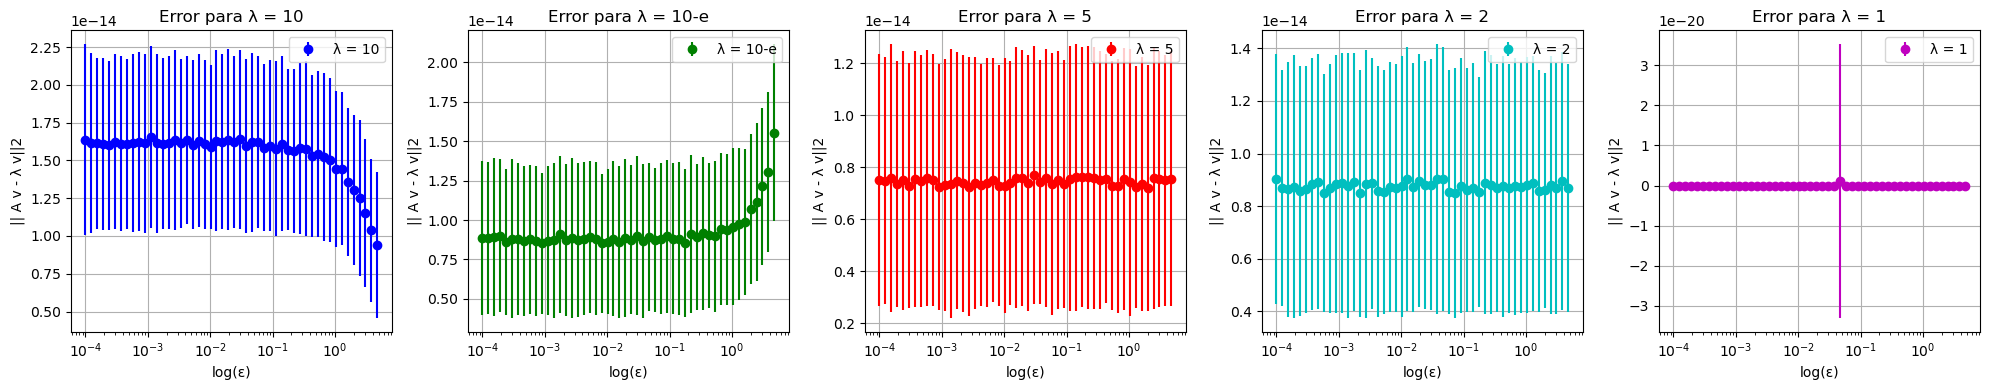

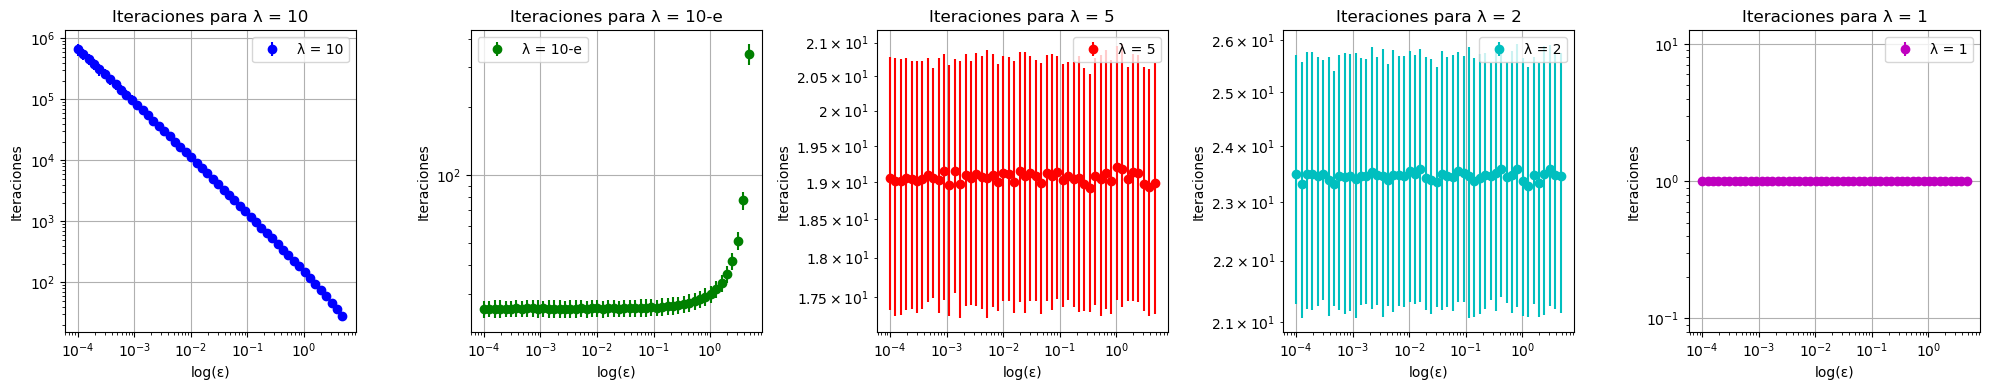

In [35]:
def convergencia(niter):
    reps = 1000

    v_epsilon = np.logspace(-4, 0.68, endpoint=True)
    eigenvalues = ["10", "10-e", "5", "2", "1"]
    errors_global = []
    niters_global = []
    std_niters_global = []
    std_errors_global = []
    for e in v_epsilon:
        eigen_errors = []
        eigen_niters = []
       
        for r in range(0, reps):
            D = np.diag([10, 10-e, 5, 2, 1]).astype(np.float64)
            v = 4*np.random.randn(D.shape[0], 1)
            v = v / np.linalg.norm(v)
            
            # Matriz de Householder
            B = np.eye(D.shape[0]) - 2 * (v @ v.T)
            
            # Matriz a diagonalizar
            M = B.T @ D @ B
            l, V, errors, niters = desglosar(metnum.power_iteration_deflation(M,5, niter, 1e-7))

            eigen_errors.append(errors)
            eigen_niters.append(niters)
        mean_errors = np.mean(np.array(eigen_errors), axis=0)
        mean_niters = np.mean(np.array(eigen_niters), axis=0)
        
        std_errors = np.std(np.array(eigen_errors), axis=0)
        std_niters = np.std(np.array(eigen_niters), axis=0)

        errors_global.append(mean_errors)
        niters_global.append(mean_niters)
        std_errors_global.append(std_errors)
        std_niters_global.append(std_niters)
        
    
    errors_global = np.array(errors_global).T # lambda filas, epsilon columna
    niters_global = np.array(niters_global).T
    std_errors_global = np.array(std_errors_global).T
    std_niters_global = np.array(std_niters_global).T
    
    colors = ['b', 'g', 'r', 'c', 'm']
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    for i in range(5):
        axs[i].errorbar(v_epsilon, errors_global[i], yerr=std_errors_global[i], fmt='o', label="λ = " + eigenvalues[i], color=colors[i])
        axs[i].set_title(f'Error para λ = {eigenvalues[i]}')
        axs[i].set_xlabel("log(ε)")
        axs[i].set_ylabel("|| A v - λ v||2")
        axs[i].set_xscale('log')
        axs[i].legend()
        axs[i].grid(True)
    plt.tight_layout()
    plt.savefig('error_metodo_deflacion.png')
    plt.show()

    # Crear subplots para iteraciones
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    for i in range(5):
        axs[i].errorbar(v_epsilon, niters_global[i], yerr=std_niters_global[i], fmt='o', label="λ = " + eigenvalues[i], color=colors[i])
        axs[i].set_title(f'Iteraciones para λ = {eigenvalues[i]}')
        axs[i].set_xlabel("log(ε)")
        axs[i].set_ylabel("Iteraciones")
        axs[i].set_xscale('log')
        axs[i].set_yscale('log')
        axs[i].legend()
        axs[i].grid(True)
    plt.tight_layout()
    plt.savefig('iteraciones_metodo_deflacion.png')
    plt.show()

convergencia(1000000)

# 3. Reconocimiento de imágenes en Fashion MNist
    

#### a - Realizar un reconocedor de imágenes usando KNN para un k fijo de 5, usando los datos de entrenamiento dados y medir la performance con la medida de exactitud en el conjunto de prueba. 

In [31]:
def image_recognizer(X_test, X_train):
    # Calculamos las distancias entre las imágenes en X_ train y  X_test
    distances_matrix = distanceMatrix(X_test, X_train)
    # Hacemos KNN, siendo los elementos de prueba los que van de 5001 al 5500
    res_knn = knn(5,distances_matrix, 0, len(distances_matrix)) 

    # Para medir la performance, comparo el resultado de knn (modas) contra el resultado real (y_test)
    correctos = np.sum(res_knn == y_test) # Calcula la cantidad de elementos que son iguales en la misma posición
    performance = correctos / len(X_test)

    print("Predicciones correctas =", correctos)
    print("Performance =", performance)

image_recognizer(X_test, X_train)


Predicciones correctas = 417
Performance = 0.834


#### b - Explorar el hiperparámetro k, usando 5-fold cross-validation con el conjunto de entrenamiento

In [ ]:
def cross_validation(start_k, end_k, X_train):
    # Precomputa la matriz de distancias entre todos los pares de puntos en X_train
    precomputo = distanceMatrix(X_train, X_train)
    # Lista para guardar el promedio de precisión para cada valor de k
    averages = []
    # Itera sobre el rango de valores de k desde start_k hasta end_k
    for k in range (start_k,end_k): 
        performances = []
         # Divide los datos en 5 bloques para la validación cruzada
        for i in range (0,5):
            start = i*1000
            end = (i+1)*1000
            
            # Calcula los k vecinos más cercanos utilizando la matriz de distancias
            res_knn = knn(k, precomputo, start, end)
            # Calcula la cantidad de elementos calculados que coinciden con su tipo original
            correctos = np.sum(res_knn == y_train[start:end])
            # Calcula la performance para el bloque actual
            performance = correctos / 1000
            # Agrega la performance del bloque actual a la lista de performances
            performances.append(performance)
        # Calcula el promedio de las performances obtenidas para el valor de k actual   
        average = np.mean(performances)
        # Agrega el promedio a la lista de promedios
        averages.append(average)
    # Encuentra el índice del mejor promedio de precisión, que corresponde al mejor k
    best_k_index = np.argmax(averages)
    # Devuelve la lista de promedios y el mejor valor de k (ajustado para ser el valor real, no el índice)
    return averages, best_k_index+1

In [ ]:
def exploracion_hiperparametro(start_k, end_k, X_train):
    ks= np.arange(start_k, end_k)
    resultados, best_k= cross_validation(start_k, end_k, X_train)

    plt.figure(figsize=(10, 6))
    plt.plot(ks, resultados, color='fuchsia')
    plt.axvline(x=best_k, color='black', linestyle='--', label=f'Máximo k={best_k}')
    plt.title('Performance de 5-fold cross validation')
    plt.xlabel('K')
    plt.ylabel('exactitud')
    plt.grid(True)
    plt.legend()
    #plt.savefig('Performance 5_fold')
    plt.show()
    
#cross_validation(1, 10, X_train)
exploracion_hiperparametro(1,100, X_train)

#### c - Preprocesar los datos de entrenamiento con PCA. Visualizar la cantidad de varianza explicada en función de la cantidad de componentes p


In [32]:
def pca(dataset, niter, err):
    # Se resta a cada valor la media de la imagen a la que pertenece (por fila)
    dataset_centered = dataset - np.mean(dataset, axis=1)[:, np.newaxis]
    # Se calcula la matriz de covarianza
    covariance_matrix = (dataset_centered.T @ dataset_centered)/ (len(dataset_centered[0])-1)
    # Encontrar autovalores y autovectores usando el método de la potencia 
    l, V, errors, niters = desglosar(metnum.power_iteration_deflation(covariance_matrix, len(covariance_matrix[0]), niter, err))
    # V matriz de autovectores , D matriz de autovalores (ordenarlas por importancia)
    D = np.diag(l).astype(np.float64)
    return V, D


# Calcula la varianza explicada en función de las p componentes  
def calculate_explaned_variance(D, p):
    variance = 0
    # Itera sobre las primeras p componentes (eigenvalores) de la matriz D
    for i in range(0,p):
        # Suma los valores de la diagonal hasta la p-ésima posición
        # donde cada elemento diagonal representa un eigenvalor de la matriz de covarianza
        variance += D[i][i]
    
    # Calcula la varianza explicada como la proporción de la suma de los primeros p eigenvalores 
    # dividida por la suma total de los eigenvalores, que es el trazo (suma de la diagonal principal) de D
    cumulative_explained_variance = variance /np.trace(D)
    
    return cumulative_explained_variance


##### experimentacion para encontrar la cantiad de iteraciones adecuadas del metodo de la potencia para pca

In [81]:
iteraciones = [1000, 5000, 10000, 15000 ,20000, 25000 ,30000]
error = 1e-7
tiempos = []
media_de_distancias = []
dataset_centered = X_train - np.mean(X_train, axis=1)[:, np.newaxis]
# Se calcula la matriz de covarianza
covariance_matrix = (dataset_centered.T @ dataset_centered)/ (len(dataset_centered[0])-1)
for i in range(0, len(iteraciones)):
    start_time = time.time()
    V, D = pca(X_train, iteraciones[i], error)
    # Marca el final del tiempo
    end_time = time.time()
    # Calcula el tiempo de ejecución
    execution_time = end_time - start_time
    tiempos.append(execution_time)
    distancias = []
    for j in range(0, len(V)):
        autovector = V[j]
        A = covariance_matrix @ autovector
        B = autovector * D[j][j]
        distancia = np.linalg.norm(A - B)
        distancias.append(distancia)
        # print(distancia)
    media_de_distancias.append(np.mean(distancias))

print(iteraciones)
print(tiempos)
print(media_de_distancias)

KeyboardInterrupt: 

In [ ]:
iteraciones = [1000, 5000, 10000, 15000 ,20000, 25000 ,30000]
x = [1, 2, 3, 4, 5, 6, 7]

plt.scatter(iteraciones, media_de_distancias)
# Añadir título y etiquetas
plt.xticks(ticks=iteraciones, labels=iteraciones)
plt.title('error de ||A*v - v*λ|| en funcion de la cantidad de iteraciones')
plt.xlabel('iteraciones')
plt.ylabel('media_de_distancias')
plt.savefig("error_powerit_vs_iteraciones")

# Mostrar el gráfico
plt.show()

#### Varianza explicada en funcion de la cantidad de componentes utilizadas

In [ ]:
variances = []
ps = []
D = 0

a =np.arange(0, 780, 20)
a[0] = 1
ps = np.append(a, 784)
V, D = pca(X_train, 10000, 1e-7)

for p in ps:
    variances.append(calculate_explaned_variance(D, p))

plt.figure(figsize=(10, 6))
plt.plot(ps, variances, color='fuchsia')
# plt.axvline(x=best_k, color='black', linestyle='--', label=f'Máximo k={best_k}')
# plt.axhline(y=max(variances), color='black', linestyle='--', label=f'Máxima varianza={str(max(variances))[:5]}')
plt.title('Varianza explicada en funcion de la cantidad de componentes utilizadas')
plt.xlabel('Ps')
plt.ylabel('Varianza')
plt.ylim(min(variances) - 0.1, 1)
plt.grid(True)
plt.legend()
plt.savefig('varianza_explicada_pca')
plt.show()



#### d - Pipeline final: Exploración conjunta de los hiperparámetros k de KNN, y p de PCA.


##### precalculamos los 5 PCAs distintos

In [37]:
# Lista para almacenar las matrices de vectores propios resultantes de cada PCA
pcas = []
niter = 10000
err = 1e-7
# Realiza un bucle sobre 5 segmentos diferentes de los datos
for i in range(0, 5):
    # Calcula los índices para dividir los datos en segmentos de 1000 ejemplos cada uno
    start_index_desarrollo = i*1000
    end_index_desarrollo = (i+1)*1000
    
    # Combina los segmentos de datos excluyendo el segmento actual para entrenar el PCA
    x_train = np.concatenate((X_train[0: start_index_desarrollo], X_train[end_index_desarrollo:]))
    
    # Ejecuta PCA en el conjunto de entrenamiento actual excluyendo el segmento i-ésimo
    V, D =  pca(x_train, niter, err)
    
    pcas.append(V)


##### cross validation con knn y pca ya precalcualdo

In [38]:
performances = []

ks = np.arange(2, 8) #valores de k para KNN
a =np.arange(0, 780, 20) # Genera valores para número de componentes PCA
a[0] = 1 # Ajusta el primer valor de a para ser 1
ps = np.append(a, 784) # Añade el valor máximo 784 al arreglo de componentes PCA

def cross_validation_pca_knn(X_train, ks, ps):
    # Inicializa la estructura para almacenar las performances
    for i in range(0, len(ks)):
        a = []
        for j in range(0, len(ps)):
            a.append([])
        performances.append(a)

    # Proceso de validación cruzada
    for i in range (0, 5): # Divide los datos en 5 bloques
        # Define los índices de los segmentos de desarrollo y entrenamiento
        start_index_desarrollo = i*1000
        end_index_desarrollo = (i+1)*1000
        x_dev = X_train[start_index_desarrollo:end_index_desarrollo]
        x_train = np.concatenate((X_train[0: start_index_desarrollo], X_train[end_index_desarrollo:]))
        
        V = pcas[i]  # Usa la matriz de componentes principales precalculada para el segmento
        for k in range(0, len(ks)):
            for p in range(0, len(ps)):
                # Proyecta los datos de entrenamiento y desarrollo usando los primeros p componentes
                x_hat_train = x_train @ V[:,:ps[p]]
                x_hat_dev = x_dev @ V[:,:ps[p]]
                
                # Calcula la matriz de distancias entre los datos proyectados
                distances = distanceMatrix(x_hat_dev, x_hat_train)
                
                # Realiza KNN con la matriz de distancias
                res_knn = knn(ks[k], distances, 0, len(distances))
                
                 # Calcula las performances
                exactitud = np.sum(res_knn == y_train[start_index_desarrollo:end_index_desarrollo]) / 1000
                performances[k][p].append(exactitud)

     # Calcula el promedio de las performances para cada combinación de k y p
    for k in range(0, len(ks)):
        for p in range(0, len(ps)):
                performances[k][p] = np.mean(performances[k][p])


    # Encuentra los índices de la mejor actuación
    indice_max = np.argmax(performances)
    indice_max_fila_columna = np.unravel_index(indice_max, np.array(performances).shape)

    return ks[indice_max_fila_columna[0]], ps[indice_max_fila_columna[1]], performances[indice_max_fila_columna[0]][indice_max_fila_columna[1]]

best_k, best_p, best_performance = cross_validation_pca_knn(X_train, ks, ps)

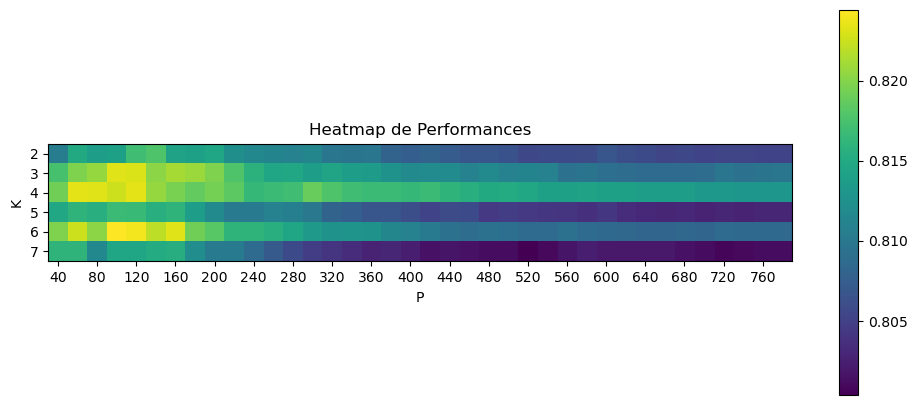

In [39]:
for i in range(0, 5):
    np.savetxt(f'pcas{i}.txt', pcas[i], fmt='%f')


interval = 2  # Mostrar cada segunda etiqueta, ajusta este valor según sea necesario
selected_ticks = np.arange(0, len(a[1: 0]), interval)

# Eliminar las primeras tres columnas de performances
p = np.delete(performances, [0, 1], axis=1)

# Crear la figura y el heatmap
plt.figure(figsize=(12, 5))
plt.imshow(p, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap de Performances')
plt.xlabel('P')
plt.ylabel('K')

# Configurar las etiquetas del eje X
# Ajustar las etiquetas a las columnas restantes

pss = np.delete(ps, [0,1])
selected_x_ticks = np.arange(0, len(pss), 2)
selected_y_ticks = np.arange(0, len(ks))
label = []

for i in selected_x_ticks:
    label.append(pss[i])

plt.xticks(ticks=selected_x_ticks, labels=label)
plt.yticks(ticks= selected_y_ticks, labels=ks)
plt.savefig("heatmap_performances")
plt.show()


In [80]:
indice_max = np.argmax(performances)

# Convertir el índice plano en un par de índices (fila, columna)
indice_max_fila_columna = np.unravel_index(indice_max, np.array(performances).shape)

print(ks[indice_max_fila_columna[0]], ps[indice_max_fila_columna[1]], performances[indice_max_fila_columna[0]][indice_max_fila_columna[1]])


6 100 0.8244


#### Gráfico de la performance de k fijo en función de p 

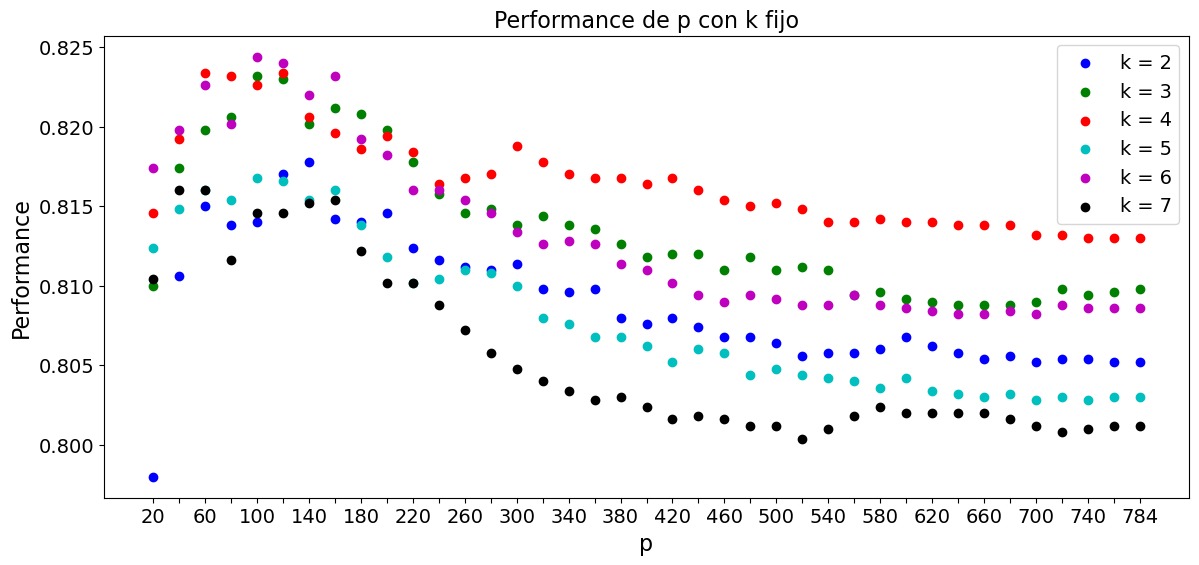

In [79]:
colors = ['b', 'g', 'r', 'c', 'm', 'black']
# fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
# Datos aleatorios para cada subgráfico
# fig.suptitle("analisis de la performance en funcion de p, con k fijo")

plt.figure(figsize=(14, 6))
for i, lista in enumerate(performances):
    x = range(len(lista[1:]))  # Generar valores de x
    y = lista[1:]
    plt.scatter(x, y, color=colors[i], label=f'k = {ks[i]}')

x_ticks = range(len(ps[1:]))
x_labels = [p if i % 2 == 0 else '' for i, p in enumerate(ps[1:])]

plt.xticks(ticks=x_ticks, labels=x_labels, fontsize=14) 
plt.title('Performance de p con k fijo', fontsize=16)
plt.yticks(fontsize=14) 
plt.xlabel('p', fontsize=16)
plt.ylabel('Performance', fontsize=16)
plt.legend(fontsize=14)
plt.savefig("performance_de_p_con_k_fijo")
plt.show()


In [54]:
def training_vs_test(best_k, best_p):
    # PCA sobre los datos de entrenamiento
    V, D = pca(X_train, 10000, 1e-7)
    # Reduccion de datos de entrenamiento a P componentes
    X_train_p = X_train @ V[:, :best_p]
    # Distancias entre las imágenes en X_ test y  X_train_p
    X_test_p = X_test @ V[:, :best_p]
    distances_matrix = distanceMatrix(X_test_p, X_train_p)
    # KNN utilizando el best_k
    res_knn = knn(best_k, distances_matrix, 0, len(distances_matrix))
    # Medimos exactitud 
    correctos = np.sum(res_knn == y_test) # Calcula la cantidad de elementos que son iguales en la misma posición
    exactitud = correctos / len(X_test)

    print("Predicciones correctas =", correctos)
    print("Performance =", exactitud)

training_vs_test(ks[indice_max_fila_columna[0]], ps[indice_max_fila_columna[1]])



Predicciones correctas = 420
Performance = 0.84
